# Code for VBM analysis
- For the pilot experiment: using GUI with scripts: ANCOVA + ESTIMATE ([https://www.fil.ion.ucl.ac.uk/~john/misc/VBMclass10.pdf])
- Code reference from: [Grégory Operto](http://xgrg.github.io/VBM-voxelwise-multiple-regression-in-Python/)
- and niLearn example: [niLearn VBM example](https://nilearn.github.io/auto_examples/02_decoding/plot_oasis_vbm.html)
- Uses subject list from:
- Uses cerebellar brain-masks from freesurfer or mni template 
## Tasks
- VBM for MNI ET/NC(38/32)
## Covariates
- Age, Sex, TBV
## Literature details:

### 1. [Benito-León, et al. “Brain Structural Changes in Essential Tremor: Voxel-Based Morphometry at 3-Tesla.” Journal of the Neurological Sciences (December 15, 2009)](https://pubmed.ncbi.nlm.nih.gov/19717167/)

    - VBM: SPM5, 2mm resolution, smmoothed with 6*6*6mm, thresholded with P<0.001 without correction;
    
    - Model: GLM(ANCOVA): 2-sammple T test with age, gender and intracranial volume as covariates

    - Study groups: **ET** (19=10+9, 69.8±9.4) verses **NC** (20=10+10, 68.9±10.0);\

### 2. [Quattrone A, Cerasa A, Messina D, Nicoletti G, Hagberg GE, Lemieux L, Novellino F, Lanza P, Arabia G, Salsone M. Essential head tremor is associated with cerebellar vermis atrophy: a volumetric and voxel-based morphometry MR imaging study. American journal of neuroradiology. 2008 Oct 1;29(9):1692-7.](http://www.ajnr.org/content/29/9/1692.short)

    - VBM: SPM2, 2mm resolution, smmoothed with 10*10*10mm, mask with th_GM<0.1, thresholded with P<0.001 at cluster level;
    
    - Model: GLM(ANCOVA): 2-sammple T test with age, gender and total gray matter volume as covariates
    
    - Multiple comparison correction: Bonferroni. 

    - covariates: age, sex, eTIV

    - Study groups: familial **ET** (50=24+26, 65.2±14.3) and **NC** (32=16+16, 66.2±8.1, arm-ET: 18/12, 61.5±16.5; head-ET: 6/14, 70.6±7.6); (stating age and sex matched for ET and NC but not for sub-group comparison.)



In [8]:
#lib and path
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../')
data_dir = Path("/codes/tab_data")
mni_fs_file  = data_dir/'freesurfer-preped_MNI.csv'
fs_file      = data_dir/'ADNI-PPMI_Des-fs_preped.csv'
suit_file    = data_dir/'ADNI-PPMI_Des-cere_preped.csv'

# Reading Participant demographics

In [9]:
## exploring data
mni_df        = pd.read_csv(mni_fs_file , sep=',', header=0, index_col=0);
other_fs_df   = pd.read_csv(fs_file , sep=',', header=0, index_col=0);
other_cere_df = pd.read_csv(suit_file   , sep=',', header=0, index_col=0);
#
SUIT_labels =['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels =['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels =['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels =['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels  =['MDTB_'+str(x+1) for x in range(10)];
Des_labels   =['_G&S_frontomargin_thickness', '_G&S_occipital_inf_thickness', '_G&S_paracentral_thickness', '_G&S_subcentral_thickness', '_G&S_transv_frontopol_thickness', '_G&S_cingul-Ant_thickness', '_G&S_cingul-Mid-Ant_thickness', '_G&S_cingul-Mid-Post_thickness', '_G_cingul-Post-dorsal_thickness', '_G_cingul-Post-ventral_thickness', '_G_cuneus_thickness', '_G_front_inf-Opercular_thickness', '_G_front_inf-Orbital_thickness', '_G_front_inf-Triangul_thickness', '_G_front_middle_thickness', '_G_front_sup_thickness', '_G_Ins_lg&S_cent_ins_thickness', '_G_insular_short_thickness', '_G_occipital_middle_thickness', '_G_occipital_sup_thickness', '_G_oc-temp_lat-fusifor_thickness', '_G_oc-temp_med-Lingual_thickness', '_G_oc-temp_med-Parahip_thickness', '_G_orbital_thickness', '_G_pariet_inf-Angular_thickness', '_G_pariet_inf-Supramar_thickness', '_G_parietal_sup_thickness', '_G_postcentral_thickness', '_G_precentral_thickness', '_G_precuneus_thickness', '_G_rectus_thickness', '_G_subcallosal_thickness', '_G_temp_sup-G_T_transv_thickness', '_G_temp_sup-Lateral_thickness', '_G_temp_sup-Plan_polar_thickness', '_G_temp_sup-Plan_tempo_thickness', '_G_temporal_inf_thickness', '_G_temporal_middle_thickness', '_Lat_Fis-ant-Horizont_thickness', '_Lat_Fis-ant-Vertical_thickness', '_Lat_Fis-post_thickness', '_Pole_occipital_thickness', '_Pole_temporal_thickness', '_S_calcarine_thickness', '_S_central_thickness', '_S_cingul-Marginalis_thickness', '_S_circular_insula_ant_thickness', '_S_circular_insula_inf_thickness', '_S_circular_insula_sup_thickness', '_S_collat_transv_ant_thickness', '_S_collat_transv_post_thickness', '_S_front_inf_thickness', '_S_front_middle_thickness', '_S_front_sup_thickness', '_S_interm_prim-Jensen_thickness', '_S_intrapariet&P_trans_thickness', '_S_oc_middle&Lunatus_thickness', '_S_oc_sup&transversal_thickness', '_S_occipital_ant_thickness', '_S_oc-temp_lat_thickness', '_S_oc-temp_med&Lingual_thickness', '_S_orbital_lateral_thickness', '_S_orbital_med-olfact_thickness', '_S_orbital-H_Shaped_thickness', '_S_parieto_occipital_thickness', '_S_pericallosal_thickness', '_S_postcentral_thickness', '_S_precentral-inf-part_thickness', '_S_precentral-sup-part_thickness', '_S_suborbital_thickness', '_S_subparietal_thickness', '_S_temporal_inf_thickness', '_S_temporal_sup_thickness', '_S_temporal_transverse_thickness', '_MeanThickness_thickness']
Des_labels = [ x.replace('-','_') for x in Des_labels]
Des_l_labels =['lh'+x for x in Des_labels]; Des_r_labels=['rh'+x for x in Des_labels]
DKT_labels   =['_caudalanteriorcingulate_thickness', '_caudalmiddlefrontal_thickness', '_cuneus_thickness', '_entorhinal_thickness', '_fusiform_thickness', '_inferiorparietal_thickness', '_inferiortemporal_thickness', '_isthmuscingulate_thickness', '_lateraloccipital_thickness', '_lateralorbitofrontal_thickness', '_lingual_thickness', '_medialorbitofrontal_thickness', '_middletemporal_thickness', '_parahippocampal_thickness', '_paracentral_thickness', '_parsopercularis_thickness', '_parsorbitalis_thickness', '_parstriangularis_thickness', '_pericalcarine_thickness', '_postcentral_thickness', '_posteriorcingulate_thickness', '_precentral_thickness', '_precuneus_thickness', '_rostralanteriorcingulate_thickness', '_rostralmiddlefrontal_thickness', '_superiorfrontal_thickness', '_superiorparietal_thickness', '_superiortemporal_thickness', '_supramarginal_thickness', '_transversetemporal_thickness', '_insula_thickness', '_MeanThickness_thickness'];
DTK_l_labels =['lh'+x for x in DKT_labels]; DTK_r_labels=['rh'+x for x in DKT_labels]
aseg_labels  =['Left_Lateral_Ventricle', 'Left_Inf_Lat_Vent', 'Left_Cerebellum_White_Matter', 'Left_Cerebellum_Cortex', 'Left_Thalamus_Proper', 'Left_Caudate', 'Left_Putamen', 'Left_Pallidum', '3rd_Ventricle', '4th_Ventricle', 'Brain_Stem', 'Left_Hippocampus', 'Left_Amygdala', 'CSF', 'Left_Accumbens_area', 'Left_VentralDC', 'Left_vessel', 'Left_choroid_plexus', 'Right_Lateral_Ventricle', 'Right_Inf_Lat_Vent', 'Right_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Thalamus_Proper', 'Right_Caudate', 'Right_Putamen', 'Right_Pallidum', 'Right_Hippocampus', 'Right_Amygdala', 'Right_Accumbens_area', 'Right_VentralDC', 'Right_vessel', 'Right_choroid_plexus', '5th_Ventricle', 'WM_hypointensities', 'Left_WM_hypointensities', 'Right_WM_hypointensities', 'non_WM_hypointensities', 'Left_non_WM_hypointensities', 'Right_non_WM_hypointensities', 'Optic_Chiasm', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent', 'BrainSegVolNotVentSurf', 'lhCortexVol', 'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol', 'TotalGrayVol', 'SupraTentorialVol', 'SupraTentorialVolNotVent', 'SupraTentorialVolNotVentVox', 'MaskVol', 'BrainSegVol_to_eTIV', 'MaskVol_to_eTIV', 'lhSurfaceHoles', 'rhSurfaceHoles', 'SurfaceHoles', 'EstimatedTotalIntraCranialVol']
wmparc_labels=['wm_lh_bankssts', 'wm_lh_caudalanteriorcingulate', 'wm_lh_caudalmiddlefrontal', 'wm_lh_cuneus', 'wm_lh_entorhinal', 'wm_lh_fusiform', 'wm_lh_inferiorparietal', 'wm_lh_inferiortemporal', 'wm_lh_isthmuscingulate', 'wm_lh_lateraloccipital', 'wm_lh_lateralorbitofrontal', 'wm_lh_lingual', 'wm_lh_medialorbitofrontal', 'wm_lh_middletemporal', 'wm_lh_parahippocampal', 'wm_lh_paracentral', 'wm_lh_parsopercularis', 'wm_lh_parsorbitalis', 'wm_lh_parstriangularis', 'wm_lh_pericalcarine', 'wm_lh_postcentral', 'wm_lh_posteriorcingulate', 'wm_lh_precentral', 'wm_lh_precuneus', 'wm_lh_rostralanteriorcingulate', 'wm_lh_rostralmiddlefrontal', 'wm_lh_superiorfrontal', 'wm_lh_superiorparietal', 'wm_lh_superiortemporal', 'wm_lh_supramarginal', 'wm_lh_frontalpole', 'wm_lh_temporalpole', 'wm_lh_transversetemporal', 'wm_lh_insula', 'wm_rh_bankssts', 'wm_rh_caudalanteriorcingulate', 'wm_rh_caudalmiddlefrontal', 'wm_rh_cuneus', 'wm_rh_entorhinal', 'wm_rh_fusiform', 'wm_rh_inferiorparietal', 'wm_rh_inferiortemporal', 'wm_rh_isthmuscingulate', 'wm_rh_lateraloccipital', 'wm_rh_lateralorbitofrontal', 'wm_rh_lingual', 'wm_rh_medialorbitofrontal', 'wm_rh_middletemporal', 'wm_rh_parahippocampal', 'wm_rh_paracentral', 'wm_rh_parsopercularis', 'wm_rh_parsorbitalis', 'wm_rh_parstriangularis', 'wm_rh_pericalcarine', 'wm_rh_postcentral', 'wm_rh_posteriorcingulate', 'wm_rh_precentral', 'wm_rh_precuneus', 'wm_rh_rostralanteriorcingulate', 'wm_rh_rostralmiddlefrontal', 'wm_rh_superiorfrontal', 'wm_rh_superiorparietal', 'wm_rh_superiortemporal', 'wm_rh_supramarginal', 'wm_rh_frontalpole', 'wm_rh_temporalpole', 'wm_rh_transversetemporal', 'wm_rh_insula', 'Left_UnsegmentedWhiteMatter', 'Right_UnsegmentedWhiteMatter', 'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'MaskVol', 'EstimatedTotalIntraCranialVol']
#
mni_df['group']=mni_df['diagnosis'];
meta_info_col = ['age','sex','group','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent']
fs_cere_col = ['Left_Cerebellum_White_Matter', 'Left_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex']
mni_data_df=mni_df[meta_info_col+fs_cere_col+SUIT_labels];
other_cere_df = other_cere_df[SUIT_labels]
other_data_df=other_fs_df[meta_info_col+fs_cere_col];
other_data_df=other_data_df.join(other_cere_df, how='left')
data_df = pd.concat([mni_data_df,other_data_df])
data_df['left_cerebellum']=data_df['Left_Cerebellum_Cortex']+data_df['Left_Cerebellum_White_Matter']
data_df['right_cerebellum']=data_df['Right_Cerebellum_Cortex']+data_df['Right_Cerebellum_White_Matter']
data_df['L_CL'] = data_df[SUIT_l_labels].sum(axis=1)
data_df['R_CL'] = data_df[SUIT_r_labels].sum(axis=1)
data_df['V_CL'] = data_df[SUIT_v_labels].sum(axis=1)
data_df['participant_id']=data_df.index
data_df=data_df[data_df['group']!='PD'];
data_df=data_df.dropna()

In [ ]:
# for MNI ET/NC pilot vbm study subject list.
tmp_df=data_df[(data_df['group']=='ET') |  (data_df['group']=='NC') ]
tmp_df['is_ET']=[1 if x=='ET' else 0 for x in tmp_df['group']]
tmp_df['is_male']=[1 if x=='M' else 0 for x in tmp_df['sex']]
tmp_df=tmp_df.sort_index()
#tmp_df[['age', 'sex', 'group', 'is_male', 'is_ET']].to_csv(data_dir / 'mni-etnc_vbm.csv')

In [11]:
# nilearn vbm
%matplotlib inline

In [13]:
# Authors: Elvis Dhomatob, <elvis.dohmatob@inria.fr>, Apr. 2014
#          Virgile Fritsch, <virgile.fritsch@inria.fr>, Apr 2014
#          Gael Varoquaux, Apr 2014
#          Andres Hoyos-Idrobo, Apr 2017
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import get_data
n_subjects = 100  # more subjects requires more memory

In [14]:
# load data
oasis_dataset = datasets.fetch_oasis_vbm(n_subjects=n_subjects)
gray_matter_map_filenames = oasis_dataset.gray_matter_maps
age = oasis_dataset.ext_vars['age'].astype(float)

# Split data into training set and test set
from sklearn.model_selection import train_test_split
gm_imgs_train, gm_imgs_test, age_train, age_test = train_test_split(
    gray_matter_map_filenames, age, train_size=.6, random_state=0)

# print basic information on the dataset
print('First gray-matter anatomy image (3D) is located at: %s' %
      oasis_dataset.gray_matter_maps[0])  # 3D data
print('First white-matter anatomy image (3D) is located at: %s' %
      oasis_dataset.white_matter_maps[0])  # 3D data


Dataset created in /home/neuro/nilearn_data/oasis1



Downloaded 903323648 of 905208634 bytes (99.8%,    0.7s remaining) ...done. (337 seconds, 5 min)
Extracting data from /home/neuro/nilearn_data/oasis1/e1dfc62a5c61f6d1d9b0266c7bebffef/archive_dartel.tgz...

First gray-matter anatomy image (3D) is located at: /home/neuro/nilearn_data/oasis1/OAS1_0001_MR1/mwrc1OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz
First white-matter anatomy image (3D) is located at: /home/neuro/nilearn_data/oasis1/OAS1_0001_MR1/mwrc2OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz


.. done.
/usr/local/miniconda/lib/python3.8/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [15]:
# preproc
nifti_masker = NiftiMasker(
    standardize=False,
    smoothing_fwhm=2,
    memory='nilearn_cache')  # cache options
gm_maps_masked = nifti_masker.fit_transform(gm_imgs_train)

# The features with too low between-subject variance are removed using
# :class:`sklearn.feature_selection.VarianceThreshold`.
from sklearn.feature_selection import VarianceThreshold
variance_threshold = VarianceThreshold(threshold=.01)
gm_maps_thresholded = variance_threshold.fit_transform(gm_maps_masked)
gm_maps_masked = variance_threshold.inverse_transform(gm_maps_thresholded)

# Then we convert the data back to the mask image in order to use it for
# decoding process
mask = nifti_masker.inverse_transform(variance_threshold.get_support())

In [21]:
variance_threshold.

VarianceThreshold(threshold=0.01)

In [16]:
# Prediction pipeline with ANOVA and SVR using :class:nilearn.decoding.DecoderRegressor Object

# In nilearn we can benefit from the built-in DecoderRegressor object to
# do ANOVA with SVR instead of manually defining the whole pipeline.
# This estimator also uses Cross Validation to select best models and ensemble
# them. Furthermore, you can pass n_jobs=<some_high_value> to the
# DecoderRegressor class to take advantage of a multi-core system.
# To save time (because these are anat images with many voxels), we include
# only the 1-percent voxels most correlated with the age variable to fit. We
# also want to set mask hyperparameter to be the mask we just obtained above.

from nilearn.decoding import DecoderRegressor
decoder = DecoderRegressor(estimator='svr', mask=mask,
                           scoring='neg_mean_absolute_error',
                           screening_percentile=1,
                           n_jobs=1)
# Fit and predict with the decoder
decoder.fit(gm_imgs_train, age_train)

# Sort test data for better visualization (trend, etc.)
perm = np.argsort(age_test)[::-1]
age_test = age_test[perm]
gm_imgs_test = np.array(gm_imgs_test)[perm]
age_pred = decoder.predict(gm_imgs_test)

prediction_score = -np.mean(decoder.cv_scores_['beta'])

print("=== DECODER ===")
print("explained variance for the cross-validation: %f" % prediction_score)
print("")

=== DECODER ===
explained variance for the cross-validation: 10.670598



/usr/local/miniconda/lib/python3.8/site-packages/nilearn/plotting/displays.py:1750: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,


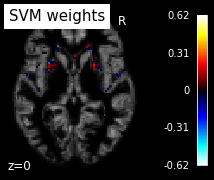

In [17]:
# vis
weight_img = decoder.coef_img_['beta']

# Create the figure
from nilearn.plotting import plot_stat_map, show
bg_filename = gray_matter_map_filenames[0]
z_slice = 0
display = plot_stat_map(weight_img, bg_img=bg_filename,
                        display_mode='z', cut_coords=[z_slice])
display.title("SVM weights")
show()

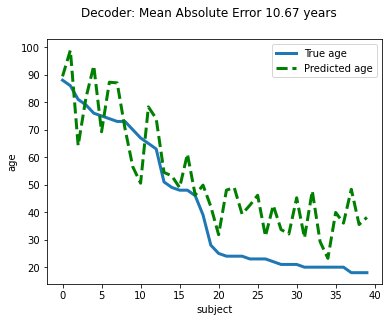

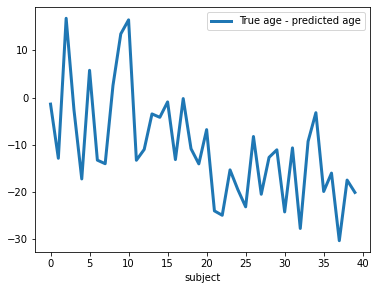

In [18]:
# vis prediction
plt.figure(figsize=(6, 4.5))
plt.suptitle("Decoder: Mean Absolute Error %.2f years" % prediction_score)
linewidth = 3
plt.plot(age_test, label="True age", linewidth=linewidth)
plt.plot(age_pred, '--', c="g", label="Predicted age", linewidth=linewidth)
plt.ylabel("age")
plt.xlabel("subject")
plt.legend(loc="best")
plt.figure(figsize=(6, 4.5))
plt.plot(age_test - age_pred, label="True age - predicted age",
         linewidth=linewidth)
plt.xlabel("subject")
plt.legend(loc="best")

Massively univariate model


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  1.2min remaining:  2.4min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.3min finished
/usr/local/miniconda/lib/python3.8/site-packages/nilearn/plotting/displays.py:1750: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,



1975 detections


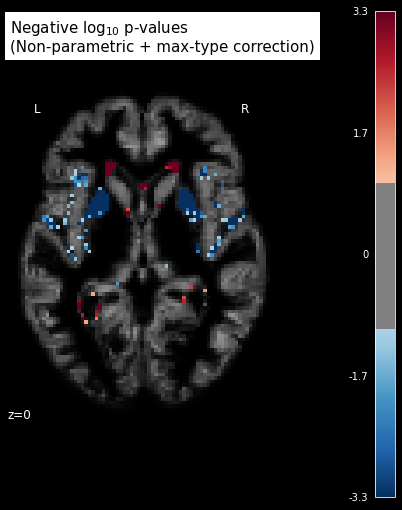

Job #5, processed 0/333 permutations (0.00%, 1960 seconds remaining)
Job #5, processed 10/333 permutations (3.00%, 64 seconds remaining)
Job #5, processed 20/333 permutations (6.01%, 59 seconds remaining)
Job #5, processed 30/333 permutations (9.01%, 57 seconds remaining)
Job #5, processed 40/333 permutations (12.01%, 56 seconds remaining)
Job #5, processed 50/333 permutations (15.02%, 53 seconds remaining)
Job #5, processed 60/333 permutations (18.02%, 52 seconds remaining)
Job #5, processed 70/333 permutations (21.02%, 50 seconds remaining)
Job #5, processed 80/333 permutations (24.02%, 49 seconds remaining)
Job #5, processed 90/333 permutations (27.03%, 49 seconds remaining)
Job #5, processed 100/333 permutations (30.03%, 47 seconds remaining)
Job #5, processed 110/333 permutations (33.03%, 46 seconds remaining)
Job #5, processed 120/333 permutations (36.04%, 44 seconds remaining)
Job #5, processed 130/333 permutations (39.04%, 42 seconds remaining)
Job #5, processed 140/333 permuta

In [20]:
#Inference with massively univariate model

print("Massively univariate model")

gm_maps_masked = NiftiMasker().fit_transform(gray_matter_map_filenames)
data = variance_threshold.fit_transform(gm_maps_masked)

# Statistical inference
from nilearn.mass_univariate import permuted_ols
neg_log_pvals, t_scores_original_data, _ = permuted_ols(
    age, data,  # + intercept as a covariate by default
    n_perm=2000,  # 1,000 in the interest of time; 10000 would be better
    verbose=1, # display progress bar
    n_jobs=6)  # can be changed to use more CPUs
signed_neg_log_pvals = neg_log_pvals * np.sign(t_scores_original_data)
signed_neg_log_pvals_unmasked = nifti_masker.inverse_transform(
    variance_threshold.inverse_transform(signed_neg_log_pvals))

# Show results
threshold = -np.log10(0.1)  # 10% corrected

fig = plt.figure(figsize=(5.5, 7.5), facecolor='k')

display = plot_stat_map(signed_neg_log_pvals_unmasked, bg_img=bg_filename,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z', cut_coords=[z_slice],
                        figure=fig)
title = ('Negative $\\log_{10}$ p-values'
         '\n(Non-parametric + max-type correction)')
display.title(title, y=1.2)

n_detections = (get_data(signed_neg_log_pvals_unmasked) > threshold).sum()
print('\n%d detections' % n_detections)

show()